In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler


SHOW_DECISION_TREES = False

In [19]:
df = pd.read_csv("/content/post_sentiment.csv")
#print(df['Unnamed: 0'])
df.drop(columns=["Unnamed: 0"], inplace=True)
print(df.columns)

Index(['name', 'blurb', 'disable_communication', 'country', 'deadline',
       'created_at', 'launched_at', 'staff_pick', 'backers_count',
       'usd_pledged', 'spotlight', 'name_len', 'name_len_clean', 'blurb_len',
       'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days',
       'launch_to_state_change_days', 'SuccessfulBool', 'USorGB', 'TOPCOUNTRY',
       'LaunchedTuesday', 'DeadlineWeekend', 'usd_goal', 'cat_Academic',
       'cat_Apps', 'cat_Blues', 'cat_Comedy', 'cat_Experimental',
       'cat_Festivals', 'cat_Flight', 'cat_Gadgets', 'cat_Hardware',
       'cat_Immersive', 'cat_Makerspaces', 'cat_Misc', 'cat_Musical',
       'cat_Places', 'cat_Plays', 'cat_Restaurants', 'cat_Robots',
       'cat_Shorts', 'cat_Software', 'cat_Sound', 'cat_Spaces',
       'cat_Thrillers', 'cat_Wearables', 'cat_Web', 'cat_Webseries',
       'usd_goal (log)', 'sharktank_wonderful', 'sharktank_wonderful_eval',
       'sharktank_daymond', 'sharktank_daymond_eval', 'sharktank_barbar

In [20]:
label_col = 'SuccessfulBool'
#numerical_data = df.select_dtypes(include=['number'])
numerical_data = df.select_dtypes(include=['number', 'bool'])
numerical_data.dropna(inplace=True)
preX = numerical_data.drop(columns=[label_col])
prey = numerical_data[label_col]

In [21]:
std_features = ['name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean',
                'create_to_launch_days', 'launch_to_deadline_days',
                'launch_to_state_change_days', 'usd_goal (log)']
scaler = StandardScaler()
preX[std_features] = scaler.fit_transform(preX[std_features])

Optimal number of features: 25
Selected optimal features: ['disable_communication', 'backers_count', 'usd_pledged', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend', 'usd_goal', 'usd_goal (log)', 'sharktank_wonderful_eval', 'sharktank_daymond_eval', 'sharktank_barbara_eval', 'sharktank_mark_eval', 'blurb_sentiment', 'sharktank_wonderful_sentiment', 'sharktank_daymond_sentiment', 'sharktank_barbara_sentiment', 'sharktank_mark_sentiment']


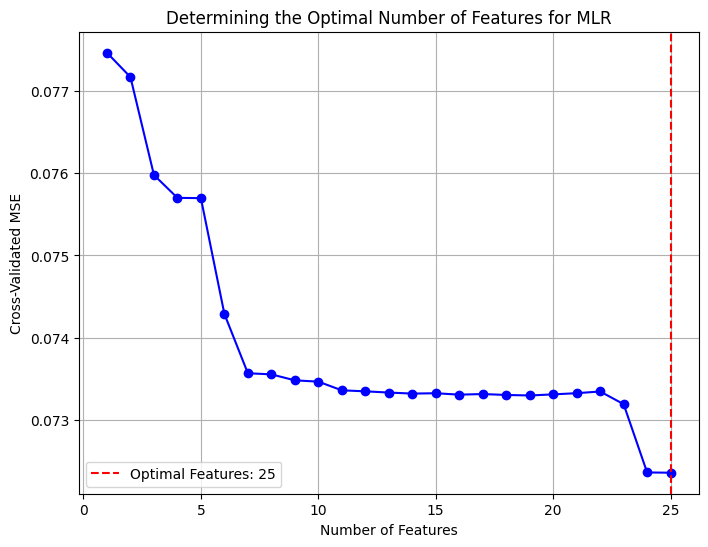

In [13]:
# Same feature importance method as before,
# but now we're determining the ideal number of features for LR using RFE cross validation

# Initialize the linear regression model
model = LinearRegression()

# Try different feature counts and evaluate model performance
num_features = list(range(1, len(preX.columns) + 1))
cv_scores = []

for n in num_features:
    # Perform Recursive Feature Elimination (RFE) with n selected features
    rfe = RFE(model, n_features_to_select=n)
    rfe.fit(preX, prey)  # Fit RFE to data

    # Compute cross-validation score (Negative MSE for minimization)
    score = np.mean(cross_val_score(model, rfe.transform(preX), prey, cv=5, scoring="neg_mean_squared_error"))
    cv_scores.append(-score)  # Convert back to positive MSE

# Determine the optimal number of features
optimal_num_features = num_features[np.argmin(cv_scores)]

# Fit RFE with the optimal number of features
rfe_optimal = RFE(model, n_features_to_select=optimal_num_features)
rfe_optimal.fit(preX, prey)

# Extract selected features
optimal_features = list(preX.columns[rfe_optimal.support_])
print(f"Optimal number of features: {optimal_num_features}")
print(f"Selected optimal features: {optimal_features}")

# Plot Number of Features vs. Validation Error
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, marker="o", linestyle="-", color="b")
plt.axvline(optimal_num_features, color='r', linestyle="--", label=f"Optimal Features: {optimal_num_features}")
plt.xlabel("Number of Features")
plt.ylabel("Cross-Validated MSE")
plt.title("Determining the Optimal Number of Features for MLR")
plt.legend()
plt.grid()
plt.show()

In [22]:
# Split data randomly into train and validation sets, fit a model to the train set
X_train, X_test, y_train, y_test = train_test_split(preX, prey, test_size=0.15, random_state=42, shuffle=True)

# We'll use Ridge Regression (L2 Regularization)
mlr = Ridge(alpha=1.0)  # Adjust alpha for more/less regularization (too lazy to automate hyperparameter tuning atm)
mlr.fit(X_train, y_train)

# Print model Coefficients
mlr_coefficients = pd.Series(mlr.coef_, index=preX.columns)
print("Model Coefficients:")
print(mlr_coefficients)

Model Coefficients:
disable_communication           -4.149291e-05
staff_pick                       1.649779e-04
backers_count                   -4.281001e-10
usd_pledged                      3.307065e-10
spotlight                        9.991248e-01
name_len                         2.604477e-06
name_len_clean                   1.338665e-05
blurb_len                       -1.272875e-05
blurb_len_clean                  7.984753e-06
create_to_launch_days            1.612193e-06
launch_to_deadline_days         -3.334463e-05
launch_to_state_change_days      3.755753e-05
USorGB                           3.186475e-05
TOPCOUNTRY                      -8.885012e-06
LaunchedTuesday                  1.029075e-05
DeadlineWeekend                 -6.207761e-06
usd_goal                         2.746311e-12
cat_Academic                    -6.491852e-05
cat_Apps                        -8.570834e-06
cat_Blues                        1.179119e-04
cat_Comedy                      -1.770921e-05
cat_Experiment

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.15468e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [23]:
def evaluate_classifiers(X, y, cv=5):
    # Model testing from Ensemble assignment with cross-validation
    features = [x for x in X.columns]
    print(f"Features: {features}")

    best_acc = 0.0
    best_clf = None
    best_std = 0.0

    # 1) Standard Decision Tree
    tree_clf = DecisionTreeClassifier(random_state=42)
    scores = cross_val_score(tree_clf, X, y, cv=cv, scoring='accuracy')
    acc_tree = scores.mean()
    std_tree = scores.std()
    print(f"{label_col}: Standard DTR accuracy: {acc_tree:.4f} ± {std_tree:.4f}")
    if acc_tree > best_acc:
        best_acc, best_clf, best_std = acc_tree, tree_clf, std_tree

    # 2) Bagging
    bag_clf = BaggingClassifier(
        DecisionTreeClassifier(random_state=42),
        n_estimators=500,
        max_samples=10,
        bootstrap=True,
        n_jobs=-1,
        random_state=42
    )
    scores = cross_val_score(bag_clf, X, y, cv=cv, scoring='accuracy')
    acc_bag = scores.mean()
    std_bag = scores.std()
    print(f"{label_col}: Bagging DTR accuracy: {acc_bag:.4f} ± {std_bag:.4f}")
    if acc_bag > best_acc:
        best_acc, best_clf, best_std = acc_bag, bag_clf, std_bag

    # 3) Random Forest (default)
    rnd_clf = RandomForestClassifier(
        n_estimators=500,
        max_leaf_nodes=16,
        n_jobs=-1,
        random_state=42
    )
    scores = cross_val_score(rnd_clf, X, y, cv=cv, scoring='accuracy')
    acc_rf = scores.mean()
    std_rf = scores.std()
    print(f"{label_col}: RFC accuracy: {acc_rf:.4f} ± {std_rf:.4f}")
    if acc_rf > best_acc:
        best_acc, best_clf, best_std = acc_rf, rnd_clf, std_rf

    # 4) AdaBoost (default)
    ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    )
    scores = cross_val_score(ada_clf, X, y, cv=cv, scoring='accuracy')
    acc_ada = scores.mean()
    std_ada = scores.std()
    print(f"{label_col}: Adaboost accuracy: {acc_ada:.4f} ± {std_ada:.4f}")
    if acc_ada > best_acc:
        best_acc, best_clf, best_std = acc_ada, ada_clf, std_ada

    # 5) RFC with varying max_depth
    for d in range(2, 8):
        clf = RandomForestClassifier(
            n_estimators=500,
            max_depth=d,
            n_jobs=-1,
            random_state=42
        )
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        acc_d = scores.mean()
        std_d = scores.std()
        print(f"{label_col}: New RFC, depth {d} accuracy: {acc_d:.4f} ± {std_d:.4f}")
        if acc_d > best_acc:
            best_acc, best_clf, best_std = acc_d, clf, std_d

    # 6) AdaBoost with varying learning rates
    ada_lrs = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
    for lr in ada_lrs:
        clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1),
            n_estimators=200,
            learning_rate=lr,
            random_state=42
        )
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        acc_lr = scores.mean()
        std_lr = scores.std()
        print(f"{label_col}: New Adaboost, LR {lr} accuracy: {acc_lr:.4f} ± {std_lr:.4f}")
        if acc_lr > best_acc:
            best_acc, best_clf, best_std = acc_lr, clf, std_lr

    print(f"\nBest model: {best_clf.__class__.__name__} with accuracy {best_acc:.4f} ± {best_std:.4f}")

    # Train on full dataset before returning
    best_clf.fit(X, y)
    return features, best_clf

In [31]:
# Evaluating classifiers with NO restraints on data (ie. providing backer counts & pledges)
features, best_model = evaluate_classifiers(preX, prey)

Features: ['disable_communication', 'staff_pick', 'backers_count', 'usd_pledged', 'spotlight', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend', 'usd_goal', 'cat_Academic', 'cat_Apps', 'cat_Blues', 'cat_Comedy', 'cat_Experimental', 'cat_Festivals', 'cat_Flight', 'cat_Gadgets', 'cat_Hardware', 'cat_Immersive', 'cat_Makerspaces', 'cat_Misc', 'cat_Musical', 'cat_Places', 'cat_Plays', 'cat_Restaurants', 'cat_Robots', 'cat_Shorts', 'cat_Software', 'cat_Sound', 'cat_Spaces', 'cat_Thrillers', 'cat_Wearables', 'cat_Web', 'cat_Webseries', 'usd_goal (log)', 'sharktank_wonderful_eval', 'sharktank_daymond_eval', 'sharktank_barbara_eval', 'sharktank_mark_eval', 'blurb_sentiment', 'sharktank_wonderful_sentiment', 'sharktank_daymond_sentiment', 'sharktank_barbara_sentiment', 'sharktank_mark_sentiment']
SuccessfulBool: Standard DTR accuracy: 1.000

In [32]:
# Evaluating classifiers WITHOUT backers counts & pledge information
inaccesible_cols = ['backers_count', 'usd_pledged']
features, best_model = evaluate_classifiers(preX.drop(columns=inaccesible_cols), prey)

Features: ['disable_communication', 'staff_pick', 'spotlight', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend', 'usd_goal', 'cat_Academic', 'cat_Apps', 'cat_Blues', 'cat_Comedy', 'cat_Experimental', 'cat_Festivals', 'cat_Flight', 'cat_Gadgets', 'cat_Hardware', 'cat_Immersive', 'cat_Makerspaces', 'cat_Misc', 'cat_Musical', 'cat_Places', 'cat_Plays', 'cat_Restaurants', 'cat_Robots', 'cat_Shorts', 'cat_Software', 'cat_Sound', 'cat_Spaces', 'cat_Thrillers', 'cat_Wearables', 'cat_Web', 'cat_Webseries', 'usd_goal (log)', 'sharktank_wonderful_eval', 'sharktank_daymond_eval', 'sharktank_barbara_eval', 'sharktank_mark_eval', 'blurb_sentiment', 'sharktank_wonderful_sentiment', 'sharktank_daymond_sentiment', 'sharktank_barbara_sentiment', 'sharktank_mark_sentiment']
SuccessfulBool: Standard DTR accuracy: 1.0000 ± 0.0000
SuccessfulBool: Baggi

In [24]:
# Evaluating classifiers WITHOUT backers counts & pledge information, and kickstarter mod information
inaccesible_cols = ['backers_count', 'usd_pledged', 'spotlight', 'staff_pick']
features, best_model = evaluate_classifiers(preX.drop(columns=inaccesible_cols), prey)

Features: ['disable_communication', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend', 'usd_goal', 'cat_Academic', 'cat_Apps', 'cat_Blues', 'cat_Comedy', 'cat_Experimental', 'cat_Festivals', 'cat_Flight', 'cat_Gadgets', 'cat_Hardware', 'cat_Immersive', 'cat_Makerspaces', 'cat_Misc', 'cat_Musical', 'cat_Places', 'cat_Plays', 'cat_Restaurants', 'cat_Robots', 'cat_Shorts', 'cat_Software', 'cat_Sound', 'cat_Spaces', 'cat_Thrillers', 'cat_Wearables', 'cat_Web', 'cat_Webseries', 'usd_goal (log)', 'sharktank_wonderful_eval', 'sharktank_daymond_eval', 'sharktank_barbara_eval', 'sharktank_mark_eval', 'blurb_sentiment', 'sharktank_wonderful_sentiment', 'sharktank_daymond_sentiment', 'sharktank_barbara_sentiment', 'sharktank_mark_sentiment']
SuccessfulBool: Standard DTR accuracy: 0.9176 ± 0.0032
SuccessfulBool: Bagging DTR accuracy: 0.9488 ± 0

In [25]:
print(best_model)
print(features)

RandomForestClassifier(max_depth=7, n_estimators=500, n_jobs=-1,
                       random_state=42)
['disable_communication', 'name_len', 'name_len_clean', 'blurb_len', 'blurb_len_clean', 'create_to_launch_days', 'launch_to_deadline_days', 'launch_to_state_change_days', 'USorGB', 'TOPCOUNTRY', 'LaunchedTuesday', 'DeadlineWeekend', 'usd_goal', 'cat_Academic', 'cat_Apps', 'cat_Blues', 'cat_Comedy', 'cat_Experimental', 'cat_Festivals', 'cat_Flight', 'cat_Gadgets', 'cat_Hardware', 'cat_Immersive', 'cat_Makerspaces', 'cat_Misc', 'cat_Musical', 'cat_Places', 'cat_Plays', 'cat_Restaurants', 'cat_Robots', 'cat_Shorts', 'cat_Software', 'cat_Sound', 'cat_Spaces', 'cat_Thrillers', 'cat_Wearables', 'cat_Web', 'cat_Webseries', 'usd_goal (log)', 'sharktank_wonderful_eval', 'sharktank_daymond_eval', 'sharktank_barbara_eval', 'sharktank_mark_eval', 'blurb_sentiment', 'sharktank_wonderful_sentiment', 'sharktank_daymond_sentiment', 'sharktank_barbara_sentiment', 'sharktank_mark_sentiment']


In [29]:
y_pred = best_model.predict(preX[features])
acc = accuracy_score(prey, y_pred)
print(f"Accuracy: {acc}")
roc_auc = roc_auc_score(prey, y_pred)
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 0.9605856401803462
ROC AUC Score: 0.9553673271831208



Model Evaluation on Test Set:
Accuracy: 0.9566
Precision: 0.9184
Recall: 0.9344
F1 Score: 0.9263


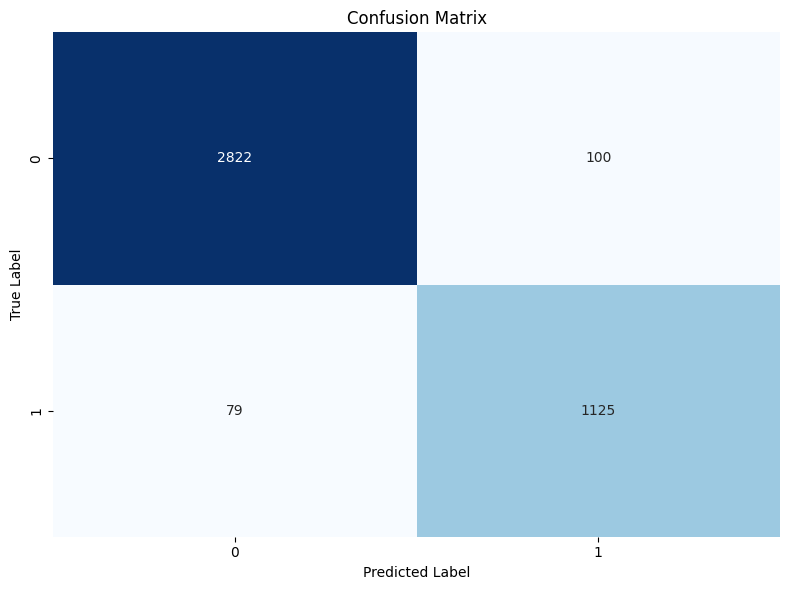


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2922
           1       0.92      0.93      0.93      1204

    accuracy                           0.96      4126
   macro avg       0.95      0.95      0.95      4126
weighted avg       0.96      0.96      0.96      4126



In [30]:
def evaluate_best_model(best_model, X, y, test_size=0.2):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    best_model.fit(X_train, y_train)

    # Make predictions on test data
    y_pred = best_model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Display results
    print(f"\nModel Evaluation on Test Set:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return y_test, y_pred


# Then call the evaluation function
y_test, y_pred = evaluate_best_model(best_model, preX[features], prey)

In [33]:
if isinstance(best_model, DecisionTreeClassifier):
    plt.figure(figsize=(200, 100))
    tree.plot_tree(best_model, feature_names=features, filled=True)
    plt.show()